In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import graphical_models as gm

from optint.data import gen_dag, random_graph, synthetic_instance
from optint.model import linearSCM
from optint.acquisition import civ_acq
from optint.utils import create_misspecified_dag
from optint.visualize import draw

from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils
import networkx as nx

In [2]:
np.random.seed(42)

p = 5
n_obs = 50          # initial observational samples
n_per_step = 10     # samples per intervention
n_steps = 5         # number of active learning steps

True DAG has 6 edges
Target mean: [ 0.46481195 -0.19134046  0.18837333 -0.26091708  0.16937468]
True B matrix: [[ 0.          0.          0.         -0.723382    0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.82961997  0.91198089  0.          0.71154713  0.        ]
 [ 0.          0.30653593  0.          0.         -0.72633551]
 [ 0.          0.          0.          0.          0.        ]]


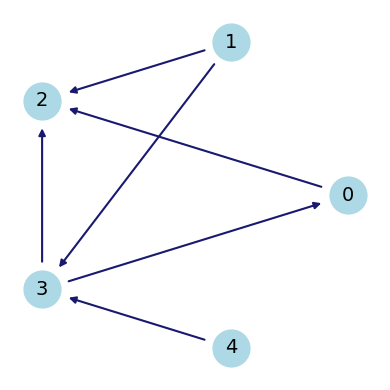

In [57]:
problem = synthetic_instance(
    nnodes=p,
    DAG_type="random",                  # or 'path', 'complete', etc.
    sigma_square = 0.5 * np.ones(p),    # noise variances
    a_size = p,                         # all nodes can be intervened on
    a_target_nodes = None,              # Will target all nodes
    std = False,
)


# Compute optimal intervention and rescale so it has unit norm
a_star_true = np.linalg.solve(np.eye(p) - problem.B, problem.mu_target)
scale_factor = np.linalg.norm(a_star_true)

# Rescale target
problem.mu_target = problem.mu_target / scale_factor
a_star_true = a_star_true / scale_factor

# Initial observational data
X_obs = problem.sample(a = np.zeros((p, 1)), n=n_obs)


print(f"True DAG has {len(problem.DAG.arcs)} edges")
print(f"Target mean: {problem.mu_target.flatten()}")
print(f"True B matrix: {problem.B}")

draw(problem.DAG)

True DAG: 6 edges
Misspecified DAG: 6 edges
True arcs: [(np.int64(0), np.int64(2)), (np.int64(1), np.int64(2)), (np.int64(1), np.int64(3)), (np.int64(3), np.int64(0)), (np.int64(3), np.int64(2)), (np.int64(4), np.int64(3))]
Wrong arcs: [(np.int64(0), np.int64(1)), (np.int64(0), np.int64(2)), (np.int64(0), np.int64(4)), (np.int64(1), np.int64(2)), (np.int64(3), np.int64(2)), (np.int64(4), np.int64(3))]


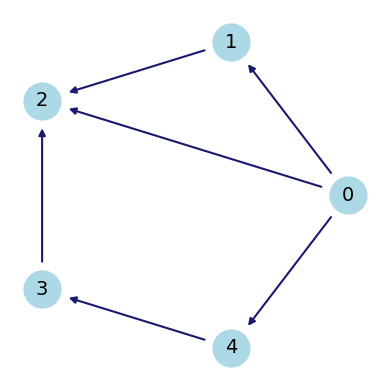

In [58]:
# Create a misspecified DAG
G_wrong = create_misspecified_dag(problem.DAG, n_changes=2)

print(f"True DAG: {len(problem.DAG.arcs)} edges")
print(f"Misspecified DAG: {len(G_wrong.arcs)} edges")
print(f"True arcs: {sorted(problem.DAG.arcs)}")
print(f"Wrong arcs: {sorted(G_wrong.arcs)}")

draw(G_wrong)

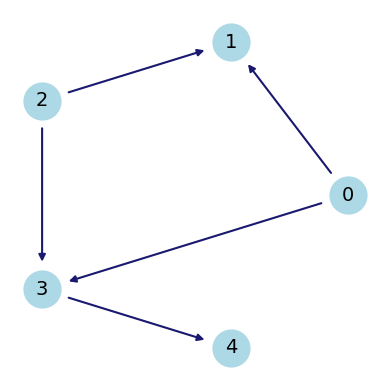

In [60]:
Record = ges(X_obs.T, score_func='local_score_BIC')
G_learned = gm.DAG(set(range(p)))

# Extract edges from GES result
learned_graph = Record['G']
for i in range(p):
    for j in range(p):
        if learned_graph.graph[i, j] == -1:
            G_learned.add_arc(i, j)

draw(G_learned)


In [61]:
print(f"\nLearned DAG: {len(G_learned.arcs)} edges")
print(f"Learned arcs: {sorted(G_learned.arcs)}")

# Compute structural Hamming distance (SHD)
true_arcs = set(problem.DAG.arcs)
learned_arcs = set(G_learned.arcs)
wrong_arcs_set = set(G_wrong.arcs)

shd_learned = len(true_arcs.symmetric_difference(learned_arcs))
shd_wrong = len(true_arcs.symmetric_difference(wrong_arcs_set))

print(f"\nStructural Hamming Distance:")
print(f"  Learned DAG: {shd_learned}")
print(f"  Misspecified DAG: {shd_wrong}")


Learned DAG: 5 edges
Learned arcs: [(0, 1), (0, 3), (2, 1), (2, 3), (3, 4)]

Structural Hamming Distance:
  Learned DAG: 11
  Misspecified DAG: 4


In [ ]:
model_oracle = linearSCM(problem.DAG, {'pot_vec': 0, 'info_mat': 1})
model_oracle.update_posterior(np.zeros((p, 1)), X_obs)

model_misspec = linearSCM(G_wrong, {'pot_vec': 0, 'info_mat': 1})
model_misspec.update_posterior(np.zeros((p, 1)), X_obs)

model_bayes = linearSCM(G_learned, {'pot_vec': 0, 'info_mat': 1})
model_bayes.update_posterior(np.zeros((p, 1)), X_obs)


interventions_oracle = []
interventions_misspec = []
interventions_bayes = []

distance_to_target_oracle = []
distance_to_target_misspec = []
distance_to_target_bayes = []

distance_to_optimal_oracle = []
distance_to_optimal_misspec = []
distance_to_optimal_bayes = []


learned_graphs = [G_learned]
shd_over_time = [shd_learned]

all_data = X_obs.copy()
all_interventions = np.zeros((p, n_obs))